# Project 1 Revisited: Importances and Coefficients

## Task
- For this assignment, you will revisit your first project to predict supermarket sales. You will apply what you've learned this week to explain how your models made their predictions.
### Project 1 Revisited - Part 1: Remaking, Saving, and Explaining Your Models
- For this part of the project, you will be producing a new version of your final project notebook using the updated tools in sklearn v1.1. 

  - Create a new notebook called "Project 1 - Revisited.ipynb" in your project repo.
    - You may either make a copy of your prior notebook that you will modify,
or you can start a new blank notebook and copy over the code from your old notebook (as needed).
- Remake your X_train and X_test as DataFrames with the feature names extracted from the column transformer instead of combining your preprocessor and model into 1 pipeline.
### LinearRegression
- Fit and evaluate your LinearRegresion model using your dataframe X_train and X_test data.
- Extract and visualize the coefficients that your model determined.
  - Select the top 3 most impactful features and interpret their coefficients in plain English.
- Save your figure as a .png file inside your repository (you will need this for the final piece of this assignment - Update Your README).
### Tree-Based Model
- Fit and evaluate your tree-based regression model using your dataframe X_train and X_test data.
- Extract and visualize the feature importances that your model determined.
  - Identify the top 5 most important features.
- Save your figure as a .png file inside your repository  (you will need this for the final piece of this assignment - Update Your README).
### Serialize Your Best Models with Joblib
- Once you've finished updating and explaining your models, you must save the following key: value pairs as a dictionary in a joblib file named "best-models.joblib":
  - "preprocessor": your preprocessing  column transformer
  - "X_train": your training features.
  - "X_test": your test features.
  - "y_train": your training target.
  - "y_test": your test target.
  - "LinearRegression": your best linear regression
  - Your tree-based model's class name: your best tree-based model.
    - e.g. "RandomForestRegressor"/"DecisionTreeRegressor"
- Save your joblib file inside your repository. (You will work with these models again in the next core assignment.)
### Update your README.
- Insert your exported figures from above into your README file. You should have the following:
  - Your LinearRegression coefficients plot.
    - Your interpretation of your coefficients.
  - Your tree-based model's feature importances.
    - Your interpretation of your feature importances. 


# Import Data and split

In [37]:
## Our standard import
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

In [2]:
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15sklearn version: 1.1.3



In [3]:
path = 'Data/sales_predictions.csv'
df = pd.read_csv(path)
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
# Fixing the description of items "Fat Content"
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg','Regular')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [7]:
y = df['Item_Outlet_Sales']
X = df.drop(columns='Item_Outlet_Sales')

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=SEED)
X_train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
8269,FDI60,7.220,Regular,0.064142,Baking Goods,61.2510,OUT010,1998,NaN,Tier 3,Grocery Store
7604,DRD25,6.135,Low Fat,0.079294,Soft Drinks,111.2860,OUT018,2009,Medium,Tier 3,Supermarket Type2
2762,NCP18,12.150,Low Fat,0.028593,Household,151.0708,OUT035,2004,Small,Tier 2,Supermarket Type1
6464,NCS30,5.945,Low Fat,0.093009,Household,127.8652,OUT035,2004,Small,Tier 2,Supermarket Type1
4707,FDI08,18.200,Regular,0.066285,Fruits and Vegetables,247.2092,OUT035,2004,Small,Tier 2,Supermarket Type1


In [8]:
## make pipelines for categorical vs numeric data
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## make the preprocessing column transformer with verbose_feature_names_out=False
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019B37927040>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000019B379275E0>)],
                  verbose_feature_names_out=False)

In [9]:
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Identifier_DRA12,Item_Identifier_DRA24,Item_Identifier_DRA59,Item_Identifier_DRB01,Item_Identifier_DRB13,Item_Identifier_DRB24,...,Outlet_Size_MISSING,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8077,15.25,0.061531,132.2968,2007.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2391,17.85,0.044463,127.1020,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
163,7.27,0.071078,114.2518,1997.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit-learn-compatible regression model using r-squared and RMSE

    Args:
        model (Regressor): Regression Model with a .predict method
        X_train (DataFrame): Training Features
        y_train (Series): Training Target
        X_test (DataFrame): Test Features
        y_test (Series): Test Target
    """

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

# LinearRegresion model

In [11]:
## fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df,y_test)

Training Data:	R^2= 0.67	RMSE= 973.12
Test Data:	R^2= -1616064500996858.25	RMSE= 70605887465.68


In [12]:
# lin_reg.coef_

In [13]:
## Checking the number of coeffs matches the # of feature names
# print(len(lin_reg.coef_))
# len(feature_names)

In [14]:
## Saving the coefficients
# coeffs = pd.Series(lin_reg.coef_, index= feature_names)
# coeffs

In [15]:
# use .loc to add the intercept to the series
# coeffs.loc['intercept'] = lin_reg.intercept_
# coeffs

In [16]:
def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

In [17]:
coeffs = get_coefficients(lin_reg)
coeffs

Item_Weight                     -2.414338e+00
Item_Visibility                 -7.951165e+02
Item_MRP                        -1.107962e+01
Outlet_Establishment_Year       -2.827941e+10
Item_Identifier_DRA12            9.532168e+11
                                     ...     
Outlet_Type_Grocery Store       -8.640491e+12
Outlet_Type_Supermarket Type1   -1.056168e+13
Outlet_Type_Supermarket Type2   -1.355875e+13
Outlet_Type_Supermarket Type3   -1.428210e+13
intercept                        5.507050e+13
Length: 1598, dtype: float64

In [18]:
## formatting numbers to not use , thousands sep, and 4 digits floats
pd.set_option('display.float_format',lambda x: f"{x:,.4f}")
pd.set_option('display.max_rows', None)

In [19]:
coeffs.sort_values()

Outlet_Type_Supermarket Type3     -14,282,095,911,651.7734
Outlet_Type_Supermarket Type2     -13,558,748,016,036.0156
Outlet_Identifier_OUT018          -13,047,104,734,012.8633
Outlet_Identifier_OUT027          -13,002,462,746,242.9102
Outlet_Identifier_OUT049          -11,181,899,942,781.7754
Outlet_Type_Supermarket Type1     -10,561,675,248,624.3809
Outlet_Type_Grocery Store          -8,640,491,411,425.6152
Outlet_Identifier_OUT035           -7,143,658,305,711.6973
Outlet_Identifier_OUT019           -4,940,198,969,573.6963
Outlet_Identifier_OUT010           -4,919,130,457,631.0830
Item_Identifier_FDS51              -4,633,557,018,868.1641
Item_Identifier_FDA39              -4,633,557,018,815.9990
Item_Identifier_FDU39              -4,633,557,018,739.5557
Item_Identifier_FDP39              -4,633,557,018,549.8633
Item_Identifier_FDS03              -4,633,557,018,220.4941
Item_Identifier_FDG31              -4,633,557,018,187.5117
Item_Identifier_FDL43              -4,633,557,018,180.15

In [20]:
## Get a list of all of the ohe columns
item_feats = [c for c in X_train_df.columns if c.startswith('Item_Identifier')]
len(item_feats)

1554

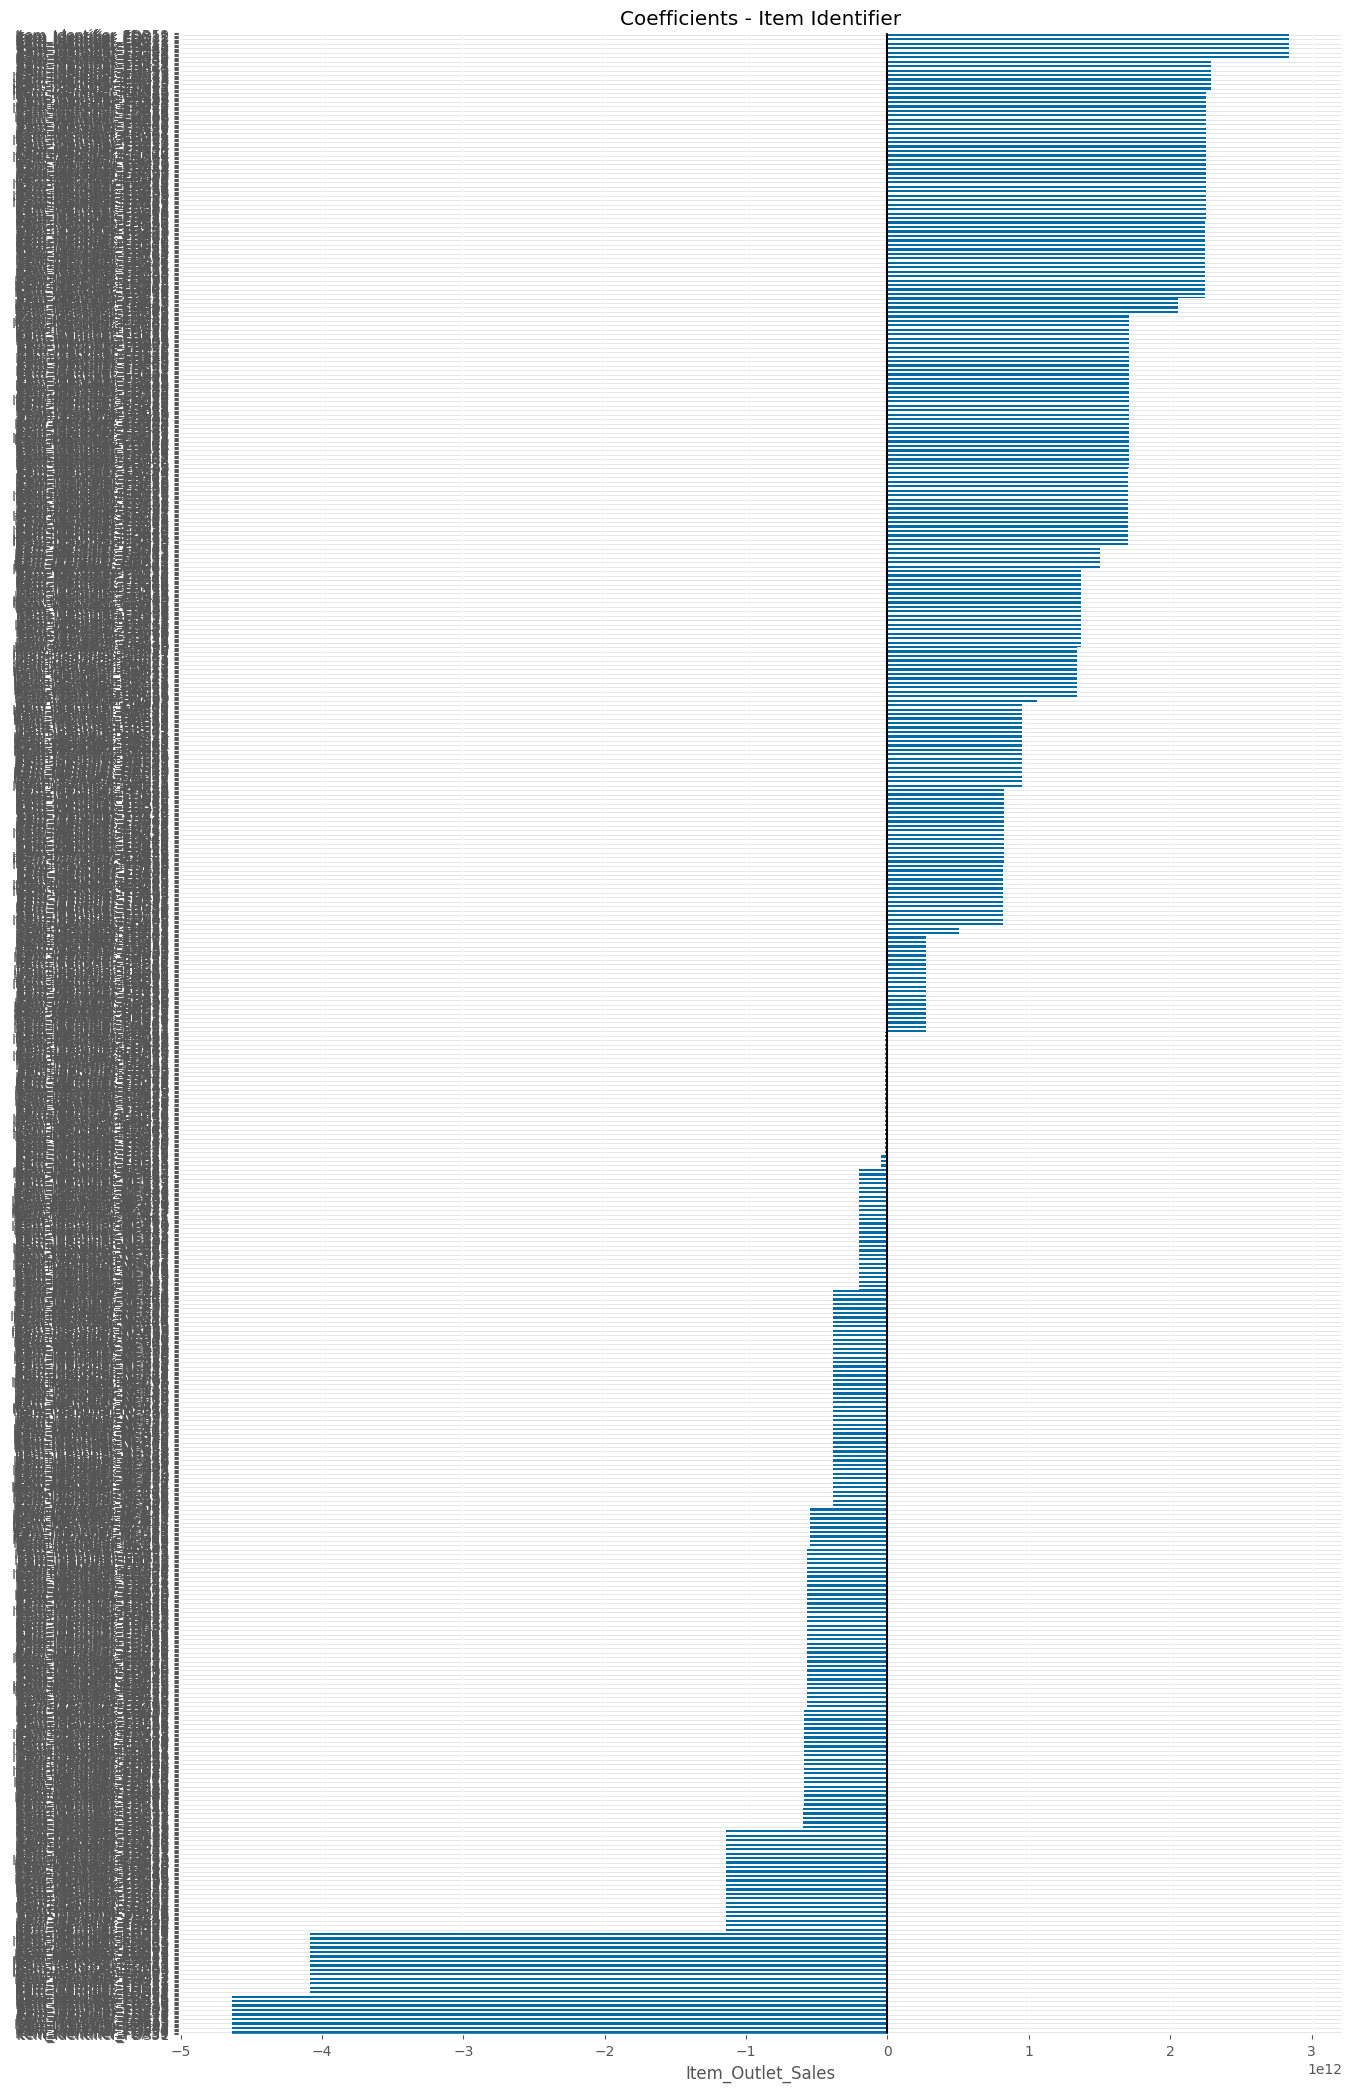

In [21]:
## Plot country coeffs
ax = coeffs[item_feats].sort_values().plot(kind='barh', figsize=(15,26))
ax.axvline(0, color='k')
ax.set(xlabel='Item_Outlet_Sales', title="Coefficients - Item Identifier");

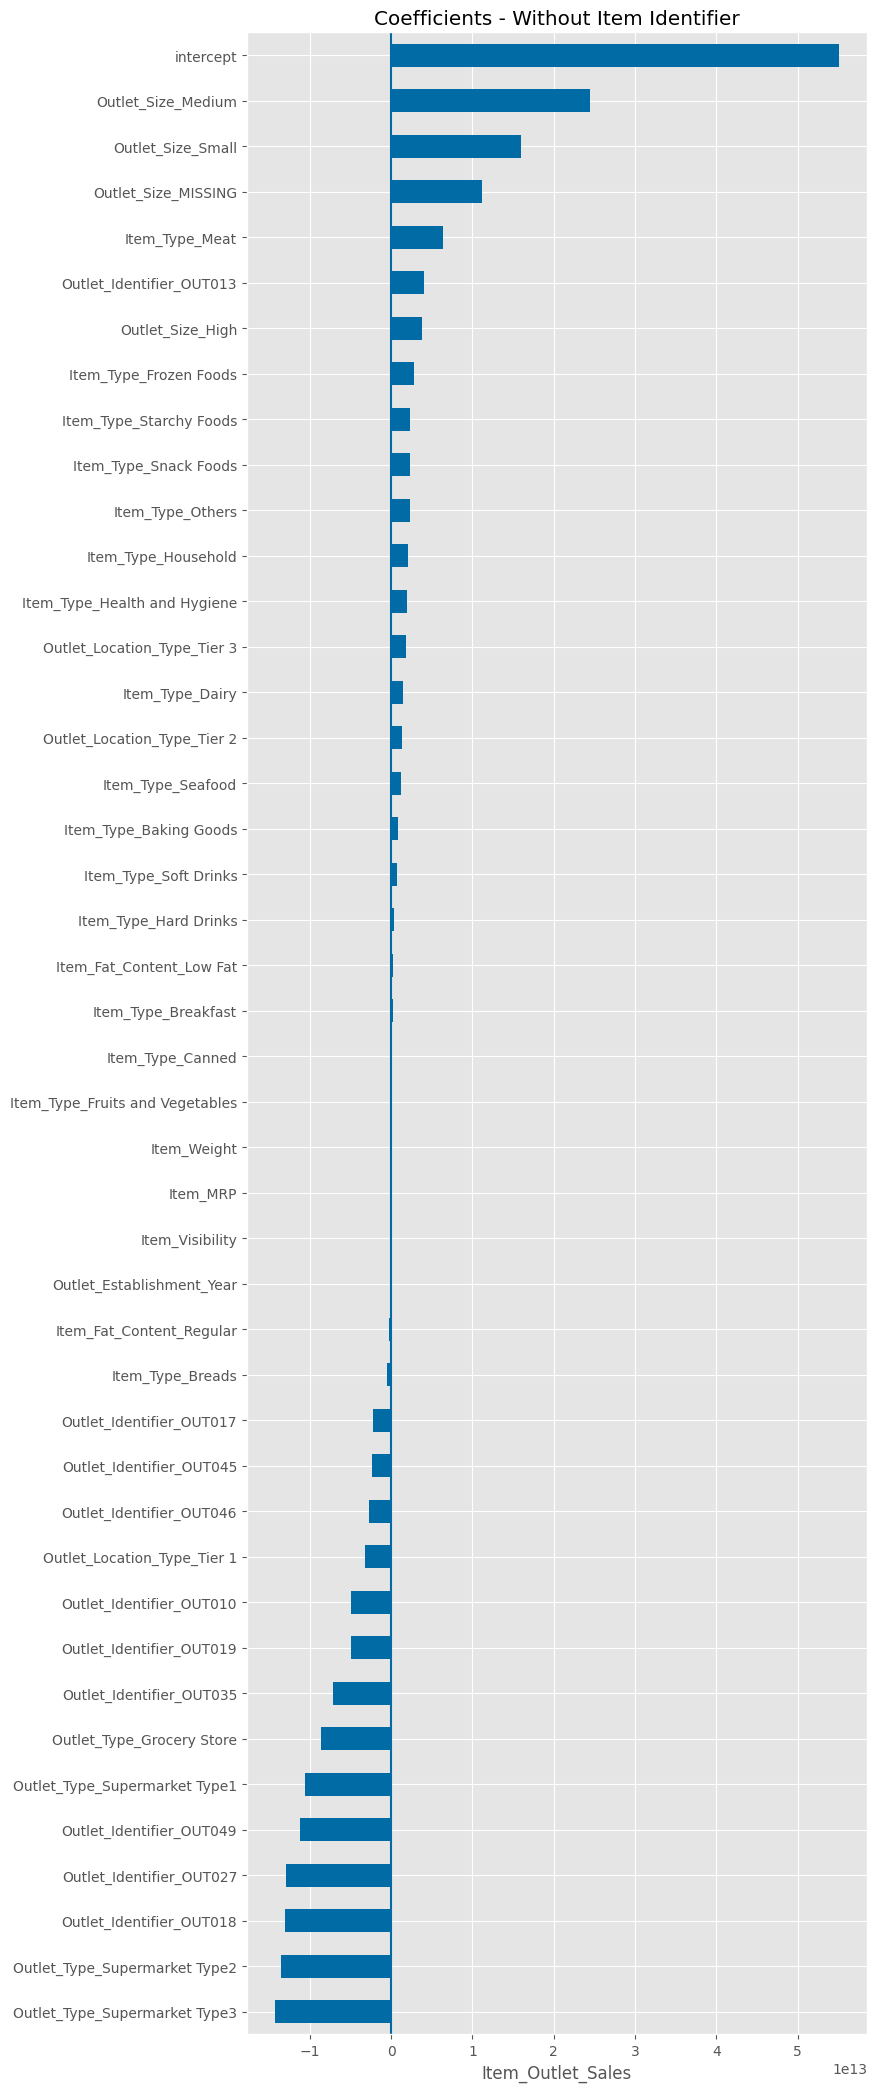

In [41]:
## Plot everything but item identifier
ax = coeffs.drop(item_feats).sort_values().plot(kind='barh', figsize=(8,26))
ax.axvline(0)
ax.set(xlabel='Item_Outlet_Sales', title="Coefficients - Without Item Identifier");

plt.savefig('Data/coeffs.png')

## Three most impactful features:
1. Outlet Size Medium
  - Being the highest coefficient indicates that stores of this size tend to have more sales overall. 
2. Outlet size small
  - Much like the first feature, the outlet size "Small" tends to impact the amount of sales as well.
3. Outlet size "Missing"
 - Unfortunately the information listed here was imputed for missing information, However, it still follows the other two features and implies that the size of the store impacts the amount of sales. Possibly the amount of inventory they hold is a factor?

# Tree-Based Model

In [23]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 422.78
Test Data:	R^2= 0.56	RMSE= 1162.59


In [26]:
## Saving the coefficients
importances = pd.Series(reg.feature_importances_, index= reg.feature_names_in_)
importances

Item_Weight                       0.0302
Item_Visibility                   0.0578
Item_MRP                          0.4040
Outlet_Establishment_Year         0.0259
Item_Identifier_DRA12             0.0001
Item_Identifier_DRA24             0.0001
Item_Identifier_DRA59             0.0003
Item_Identifier_DRB01             0.0008
Item_Identifier_DRB13             0.0001
Item_Identifier_DRB24             0.0001
Item_Identifier_DRB25             0.0000
Item_Identifier_DRB48             0.0000
Item_Identifier_DRC01             0.0000
Item_Identifier_DRC12             0.0000
Item_Identifier_DRC13             0.0000
Item_Identifier_DRC24             0.0000
Item_Identifier_DRC25             0.0000
Item_Identifier_DRC27             0.0001
Item_Identifier_DRC36             0.0001
Item_Identifier_DRC49             0.0000
Item_Identifier_DRD01             0.0000
Item_Identifier_DRD12             0.0000
Item_Identifier_DRD13             0.0000
Item_Identifier_DRD15             0.0000
Item_Identifier_

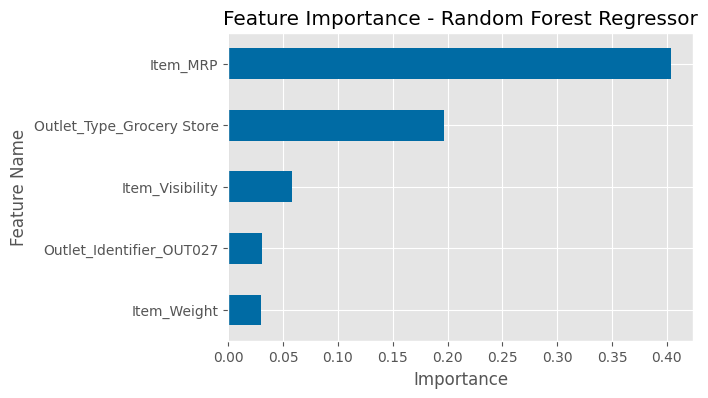

In [42]:
ax = importances.sort_values().tail(5).plot(kind='barh',figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Random Forest Regressor',ylabel="Feature Name",
      xlabel='Importance');

plt.savefig('Data/importances.png')

## Five most important features.
1. Item Market retail Price
 - This goes without saying, the item price is a big factor in outlet sales.
2. Outlet Type "Grocery Store"
 - Being a grocery store would bring in more sales as food is consistently being replaced and purchased on a regular basis.
3. Item Visibility
 - Visually appealing and grabbing customers attention and "persuading" the purchase of the item.
4. Outlet ID "Out 27"
 - Unfortunately we do not have much insight on this feature, but perhaps this type of outlet is popular with consumers.
5. Item Weight
 - The item weight possibly correlates with item sales. the lighter the package and item the more they are purchased.

# Serialize Our Best Model with Joblib

In [43]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 422.78
Test Data:	R^2= 0.56	RMSE= 1162.59


In [44]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest':reg}
joblib.dump(export, 'random_forest_l01.joblib')

['random_forest_l01.joblib']